In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skab-anomaly-detection/SKAB-master/LICENSE
/kaggle/input/skab-anomaly-detection/SKAB-master/.gitignore
/kaggle/input/skab-anomaly-detection/SKAB-master/README.md
/kaggle/input/skab-anomaly-detection/SKAB-master/utils/t2.py
/kaggle/input/skab-anomaly-detection/SKAB-master/utils/__init__.py
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/contributing.md
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/skab.png
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/testbed.png
/kaggle/input/skab-anomaly-detection/SKAB-master/docs/pictures/nab-metric.jpg
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/hotelling_q.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/mscred.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/isolation_forest.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/VAE.ipynb
/kaggle/input/skab-anomaly-detection/SKAB-master/notebooks/LSTM-AE.ipynb
/kaggle/input/skab-anomaly-d

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

# Introductory Summary

1.  Dataset : SKAB (SkoltechAnomaly Benchmark) / Multivariate time series collected from the sensors on the testbed
1.  Framework : Tensorflow Keras
1.  Model : 1D Convolutional Autoencoder
1.  Activation Function : ReLU


* ###  Data Summary

In [3]:
#Paths of data files
all_files =[]
for root, dirs, files in os.walk('/kaggle/input/skab-anomaly-detection/SKAB-master/data/'):
    for file in files:
        if file.endswith('.csv'):
            all_files.append(os.path.join(root,file))

#Data with outliers included         
list_of_df = [pd.read_csv(file,
                            sep = ';',
                            index_col = 'datetime',
                            ) for file in all_files if 'anomaly-free' not in file]

#Anomaly free data
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0],
                             sep = ';',
                             index_col = 'datetime')



In [4]:
print('이상치 포함된 DataFrame {}개'.format(len(list_of_df)))
for i in range(len(list_of_df)) : print(list_of_df[i].columns, list_of_df[i].shape)
print('\n이상치 없는 데이터')
print(anomaly_free_df)
print('Number of change points :',sum([len(df[df.changepoint == 1.0])for df in list_of_df]) )
print('Number of outliers :',sum([len(df[df.anomaly == 1.0])for df in list_of_df]) )

df = list_of_df[1] #첫번째 데이터 사용!

이상치 포함된 DataFrame 34개
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1063, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (995, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1129, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object') (1125, 10)
Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow R

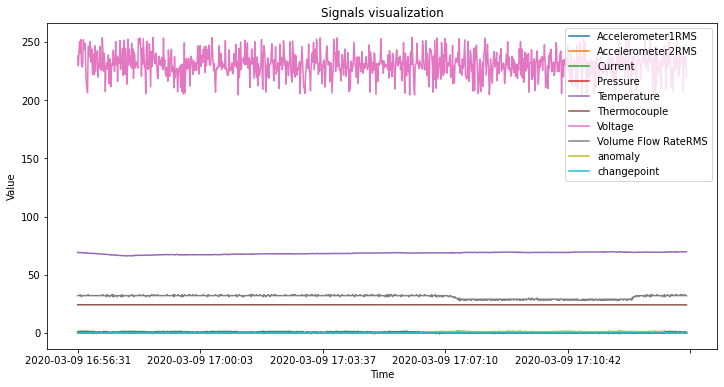

In [5]:
#시각화
df.plot(figsize = (12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals visualization')
plt.show()

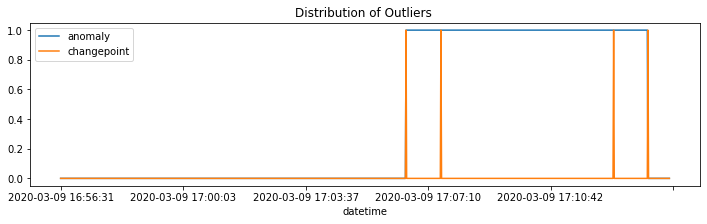

In [6]:
#이상치 분포
df['anomaly'].plot(figsize = (12,3))
df['changepoint'].plot()
plt.legend()
plt.title('Distribution of Outliers ')
plt.show()


* ### Model Pipeline and Preprocessing


In [7]:
# Random Seed
def Random(seed_value):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    import random
    random.seed(seed_value)
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [8]:
#Convolutional AutoEncoder
def convae(data):

    model = keras.Sequential([ 
        
        layers.Input(shape = (data.shape[1], data.shape[2])),
        layers.Conv1D(filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1D(filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 16, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 32, kernel_size = 7, padding = 'same', strides = 2, activation = 'relu' ),
        layers.Conv1DTranspose(filters = 8, kernel_size = 7, padding = 'same'),  # shape 일치시키기 위한 layer(오토인코더 구조) 
    
    ])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = 'mse')
    
    model.summary()

    # Training
    history = model.fit(        
        data,
        data, # data X instead of Y because it's unsupervised learning
        epochs = 100,
        batch_size = 32,
        verbose = 2,

        # early stopping 자동 학습 중단. patience 5번 loss 상승시 중단
        callbacks = [
            keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)
        ]

    )
    return history, model

In [9]:
#Preprocessing
X_train = df[:400].drop(columns = ['anomaly','changepoint'], axis = 1) ##0~400번까지 모두 정상데이터이므로 학습데이터로 선정
StSc = StandardScaler()
X_train_scale = StSc.fit(X_train)   ## Standardization(표준) : train data의 평균, 분산분포를 저장. 추후에 test data에도 똑같이 적용필요
X_train_scale = StSc.transform(X_train)


In [10]:
# sequence를 고려한 전처리
# 데이터를 임의의 sequence 묶음
def create_sequences(data, time_steps = 60):
    out = []
    for i in range(len(data) - time_steps + 1):
        out.append(data[i : (i + time_steps)])
    return np.stack(out)

X_train_seq = create_sequences(X_train_scale,60) #400의 정상데이터를 60개의 묶음으로 1씩 shift 하며 묶음 -> 341개 생성
X_train_seq.shape 

(341, 60, 8)

In [11]:
history, model = convae(X_train_seq)

2023-02-07 14:38:16.498139: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            1824      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 30, 16)            1808      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 60, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 60, 8)             1800      
Total params: 12,648
Trainable params: 12,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-02-07 14:38:16.744957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


11/11 - 1s - loss: 0.9347
Epoch 2/100
11/11 - 0s - loss: 0.8228
Epoch 3/100
11/11 - 0s - loss: 0.7206
Epoch 4/100
11/11 - 0s - loss: 0.6672
Epoch 5/100
11/11 - 0s - loss: 0.6206
Epoch 6/100
11/11 - 0s - loss: 0.5796
Epoch 7/100
11/11 - 0s - loss: 0.5403
Epoch 8/100
11/11 - 0s - loss: 0.5050
Epoch 9/100
11/11 - 0s - loss: 0.4702
Epoch 10/100
11/11 - 0s - loss: 0.4378
Epoch 11/100
11/11 - 0s - loss: 0.4094
Epoch 12/100
11/11 - 0s - loss: 0.3851
Epoch 13/100
11/11 - 0s - loss: 0.3645
Epoch 14/100
11/11 - 0s - loss: 0.3462
Epoch 15/100
11/11 - 0s - loss: 0.3303
Epoch 16/100
11/11 - 0s - loss: 0.3158
Epoch 17/100
11/11 - 0s - loss: 0.3023
Epoch 18/100
11/11 - 0s - loss: 0.2899
Epoch 19/100
11/11 - 0s - loss: 0.2786
Epoch 20/100
11/11 - 0s - loss: 0.2681
Epoch 21/100
11/11 - 0s - loss: 0.2591
Epoch 22/100
11/11 - 0s - loss: 0.2503
Epoch 23/100
11/11 - 0s - loss: 0.2426
Epoch 24/100
11/11 - 0s - loss: 0.2358
Epoch 25/100
11/11 - 0s - loss: 0.2293
Epoch 26/100
11/11 - 0s - loss: 0.2242
Epoch 2

* ### Anomaly Scoring & Result

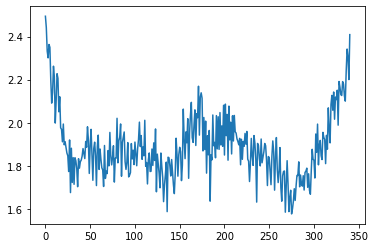

In [12]:
residuals = pd.Series(np.sum(np.mean(np.abs(X_train_seq - model.predict(X_train_seq)), axis = 1), axis = 1)) # input data와 reconstructed input의 차이값
ucl = residuals.quantile(0.999) # 차이값의 전체 분포에서 상위 99.9%지점을 upper control limit으로 지정
plt.plot(residuals) ## value gap between input VS reconstructed input for anomaly-free data
plt.show()

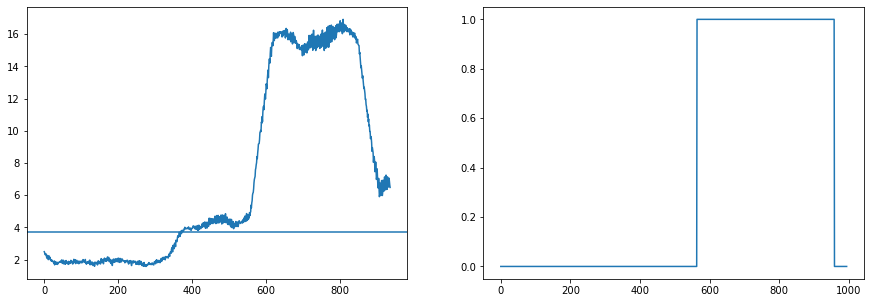

In [13]:
X_test_sc = StSc.transform(df.drop(columns = ['anomaly','changepoint']))  #400번째 이후 이상치 데이터 모두 포함하여 test data 지정
X_test_seq = create_sequences(X_test_sc)
test_residuals = pd.Series(np.sum(np.mean(np.abs(X_test_seq - model.predict(X_test_seq)), axis = 1), axis = 1))
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(test_residuals)
plt.axhline(y = ucl * 1.5 , xmin = 0, xmax=len(X_train_seq))  # upper control limit 의 1.5배를 Threshold 로 설정
plt.subplot(1,2,2)
plt.plot(df['anomaly'].values)

In [14]:
# 비교를 위해 label값을 time 단위로 변경
N_STEPS = 60
anomalous_data = test_residuals > ucl * 1.5

anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X_test_seq) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
    

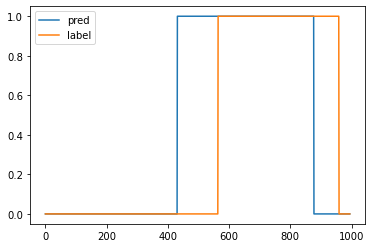

In [15]:
prediction = pd.Series(data = 0, index = df.index)
prediction.iloc[anomalous_data_indices] = 1

plt.plot(prediction.values, label = 'pred')
plt.plot(df['anomaly'].values, label = 'label')
plt.legend()
plt.show()